

# A2C GridWorld(Without buffer)

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class GridEnvironment(gym.Env):
    
    def __init__(self, environment_type, max_timesteps):

        self.environment_type = environment_type
        self.environment_width = 4
        self.environment_height = 4

        self.observation_space = spaces.Discrete(self.environment_width * self.environment_height)
        self.action_space = spaces.Discrete(4)

        self.number_of_agents = 1
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3, 3])

        self.candy_pos = np.asarray([0, 3])
        self.diamond_pos = np.asarray([1, 3])
        self.coin_pos = np.asarray([2, 1])

        self.gold_collected = False
        self.candy_collected = False
        self.diamond_collected = False
        self.coin_collected = False


        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.candy_pos)] = 0.4
        self.state[tuple(self.diamond_pos)] = 0.3
        self.state[tuple(self.coin_pos)] = 0.2
        
        self.timestep = 0
        self.max_timesteps = max_timesteps
        self.epsilon = 0.9


        
    def reset(self):
        self.timestep = 0
        self.agent_pos = np.asarray([0, 0])
        self.goal_pos = np.asarray([3, 3])
        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        self.gold_collected = False
        self.candy_collected = False
        self.diamond_collected = False
        self.coin_collected = False
        
        return observation
    
    def step(self, action: int):
        #rand_num = np.random.random()

        # if self.environment_type != "deterministic":
        #   if np.random.random() > self.epsilon: # exploitation
        #       action = random.choice([0,1,2,3])
         
        if action == 0:
            self.agent_pos[1] += 1 # right
        if action == 1:
          self.agent_pos[0] += 1 # down
        if action == 2:
          self.agent_pos[1] -= 1 # left
        if action == 3:
          self.agent_pos[0] -= 1 # up
        

        self.agent_pos = list(np.clip(self.agent_pos, 0, 3))
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        
        self.state[tuple(self.candy_pos)] = 0.4
        self.state[tuple(self.diamond_pos)] = 0.3
        self.state[tuple(self.coin_pos)] = 0.2


        observation = self.state.flatten()
        
        reward = -1
        terminal_state_reached = False
        if (self.agent_pos == self.goal_pos).all():
            terminal_state_reached = True
            if not self.gold_collected:
              reward = 10
              self.gold_collected = True

        # if (self.agent_pos == self.diamond_pos).all():
        #   if not self.diamond_collected:
        #       reward = 5
        #       self.diamond_collected = True
            
        # if (self.agent_pos == self.candy_pos).all():
        #   if not self.candy_collected:
        #       reward = 3
        #       self.candy_collected = True
            
        # if (self.agent_pos == self.coin_pos).all():
        #   if not self.coin_collected:
        #       reward = 1
        #       self.coin_collected = True
            
        self.timestep += 1
        done = True if (self.timestep > self.max_timesteps) or terminal_state_reached else False
        
        
        info = {}
        action_new = action
        
        return observation, reward, done,terminal_state_reached, action_new


    def render(self):
        plt.figure()
        plt.imshow(self.state)


In [ ]:
class Actor(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Actor, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          #self.action_space_len = action_space_len
          self.actor_net = nn.Sequential(nn.Linear(state_space_len, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, action_space_len))
      
    def policy(self,x):
      output = self.actor_net(x)
      return F.softmax(output, dim=-1)
    
    
class Critic(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Critic, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None
          
          self.critic_net = nn.Sequential(nn.Linear(state_space_len, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 1))

          
          
    def v(self,x):
      
      return self.critic_net(x)
    

In [ ]:
def calculate_discountedRewards(rewards,V,dones,gamma = 0.99):
    # bootstrapping from last value
    vals = []
    i = len(rewards)-1
    while i!=-1:
      V = rewards[i] + gamma * V * dones[i]
      vals.insert(0,V)
      i-=1
    return vals


In [ ]:
from collections import defaultdict

def train_step(log_prob_actions,values,rewards,dones,last_value):
    TD_target = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach()
    
    advantages = TD_target - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    

    optimizer_actor.step()
    optimizer_critic.step()



episode =  0 mean reward =  -56.0
episode =  100 mean reward =  -0.86
episode =  200 mean reward =  4.0
episode =  300 mean reward =  4.59
episode =  400 mean reward =  4.94


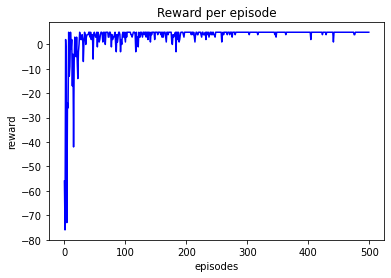

episode =  500 mean reward =  4.89
episode =  600 mean reward =  4.96
episode =  700 mean reward =  4.99
episode =  800 mean reward =  4.97
episode =  900 mean reward =  4.99


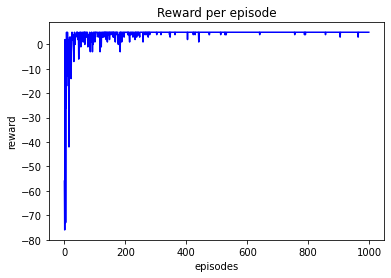

Complete


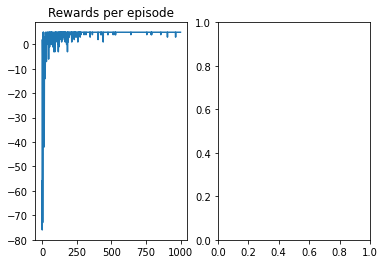

In [ ]:
#from numpy.random.mtrand import seed
#from gym.spaces.discrete import Discrete # Scale reward [-1,1]
from torch.distributions import Categorical
#BATCH_SIZE = 64 #200 # around 32 for cartpole
GAMMA = 0.99 #0.999

learning_rate_critic = 1e-2 #1e-3
learning_rate_actor = 1e-3 #5e-4



#max_step = 100 #2000
num_episodes = 1000
rewards_per_episode = []
max_step = 100

env = GridEnvironment("deterministic",max_timesteps=max_step)
#torch.manual_seed(321)
env.seed(321)
#Discrete
n_actions = env.action_space.n


actor = Actor(env.observation_space.n,env.action_space.n)
critic = Critic(env.observation_space.n,env.action_space.n)


optimizer_actor = optim.Adam(actor.parameters(),lr = learning_rate_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)




for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    log_prob_actions = []
    values = []
    rewards = []
    dones = []
    curr_episode_reward = 0
    env.seed(1234)

    for t in count():
        # Select and perform an action    
        
        state = torch.FloatTensor(state)
        probs = actor.policy(state) # actor
        value = critic.v(state)  #critic

        dist = Categorical(probs)
        action = dist.sample()

        log_prob_action = dist.log_prob(action).unsqueeze(0) #get log probabilities
        prev_state = state
        state, reward, done,terminal_state_reached,_ = env.step(action.cpu().numpy())

        log_prob_actions.append(log_prob_action)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float))
        dones.append(torch.tensor([1 - done], dtype=torch.float))
        curr_episode_reward += reward
        
        if done:
            break

    last_value = critic.v(torch.FloatTensor(state))
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values)
    
    advantages = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach() - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizer_actor.step()
    optimizer_critic.step()
    #train_step(log_prob_actions,values,rewards,dones,last_value)


    

    rewards_per_episode.append(curr_episode_reward)

    if i_episode % 100 == 0:
        mean_reward = (np.mean(rewards_per_episode[-100:]))
        print('episode = ',i_episode, "mean reward = ", mean_reward)
    
    
    if (i_episode+1)%500==0:

      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
      
      

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

# ax[1].set_title('Epsilon decay')
# ax[1].plot(epsilon_per_episode)

#plt.savefig("Assignment2_GridWorld.png",dpi=1200)
plt.show()

Complete


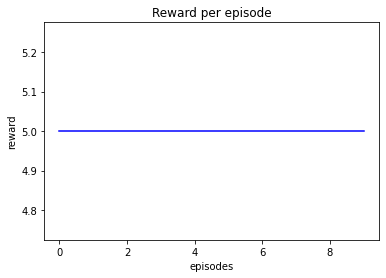

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        probs = actor.policy(torch.from_numpy(state).float().unsqueeze(0))
        action = Categorical(probs).sample().item()#.numpy()
        
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done,terminal_state_reached,_ = env.step(action)
        
        curr_episode_reward += reward

        # Move to the next state
        state = next_state

        if done:
            break 
   
    rewards_per_episode.append(curr_episode_reward)
   

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
#plt.savefig("Gridworld_evaluation.png",dpi=1200)




# A2C CartPole(Without buffer)

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.3 MB 33.1 MB/s 
     |████████████████████████████████| 1.8 MB 32.1 MB/s 
     |████████████████████████████████| 2.1 MB 35.1 MB/s 


In [ ]:
class Actor(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Actor, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          #self.action_space_len = action_space_len
          self.actor_net = nn.Sequential(nn.Linear(state_space_len, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, action_space_len))
      
    def policy(self,x):
      output = self.actor_net(x)
      return F.softmax(output, dim=-1)
    
    
class Critic(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Critic, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None
          
          self.critic_net = nn.Sequential(nn.Linear(state_space_len, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 1))

          
          
    def v(self,x):
      
      return self.critic_net(x)
    

In [ ]:
def calculate_discountedRewards(rewards,V,dones,gamma = 0.99):
    # bootstrapping from last value
    vals = []
    i = len(rewards)-1
    while i!=-1:
      V = rewards[i] + gamma * V * dones[i]
      vals.insert(0,V)
      i-=1
    return vals


In [ ]:
from collections import defaultdict

def train_step(log_prob_actions,values,rewards,dones,last_value):
    TD_target = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach()
    
    advantages = TD_target - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    

    optimizer_actor.step()
    optimizer_critic.step()



episode =  0 mean reward =  10.0
episode =  100 mean reward =  49.99
episode =  200 mean reward =  361.84
episode =  300 mean reward =  413.87
episode =  400 mean reward =  465.13


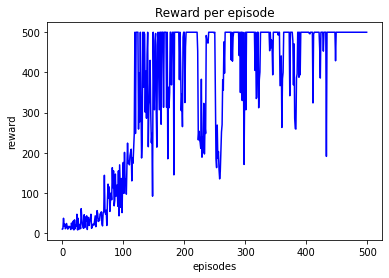

episode =  500 mean reward =  492.3
episode =  600 mean reward =  481.89
episode =  700 mean reward =  465.51
episode =  800 mean reward =  493.45
episode =  900 mean reward =  486.16


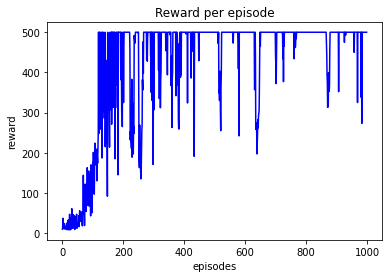

Complete


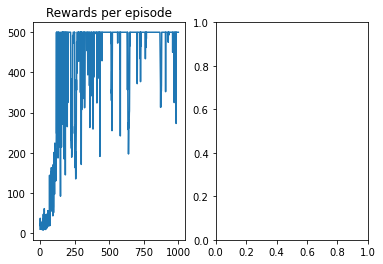

In [ ]:
#from numpy.random.mtrand import seed
#from gym.spaces.discrete import Discrete # Scale reward [-1,1]
from torch.distributions import Categorical
#BATCH_SIZE = 64 #200 # around 32 for cartpole
GAMMA = 0.99 #0.999

learning_rate_critic = 1e-2 #1e-3
learning_rate_actor = 1e-3 #5e-4



#max_step = 100 #2000
num_episodes = 1000
rewards_per_episode = []

env = gym.make("CartPole-v1")
#torch.manual_seed(321)
env.seed(321)
#Discrete
n_actions = env.action_space.n


actor = Actor(env.observation_space.shape[0],env.action_space.n)
critic = Critic(env.observation_space.shape[0],env.action_space.n)


optimizer_actor = optim.Adam(actor.parameters(),lr = learning_rate_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)




for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    log_prob_actions = []
    values = []
    rewards = []
    dones = []
    curr_episode_reward = 0
    env.seed(1234)

    for t in count():
        # Select and perform an action    
        
        state = torch.FloatTensor(state)
        probs = actor.policy(state) # actor
        value = critic.v(state)  #critic

        dist = Categorical(probs)
        action = dist.sample()

        log_prob_action = dist.log_prob(action).unsqueeze(0) #get log probabilities
        prev_state = state
        state, reward, done,_ = env.step(action.cpu().numpy())
        #reward = 100*((math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]) - (math.sin(3*prev_state[0]) * 0.0025 + 0.5 * prev_state[1] * prev_state[1]))

        log_prob_actions.append(log_prob_action)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float))
        dones.append(torch.tensor([1 - done], dtype=torch.float))
        curr_episode_reward += reward
        
        if done:
            break

    last_value = critic.v(torch.FloatTensor(state))
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values)
    
    advantages = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach() - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizer_actor.step()
    optimizer_critic.step()
    #train_step(log_prob_actions,values,rewards,dones,last_value)


    

    rewards_per_episode.append(curr_episode_reward)

    if i_episode % 100 == 0:
        mean_reward = (np.mean(rewards_per_episode[-100:]))
        print('episode = ',i_episode, "mean reward = ", mean_reward)
    
    
    if (i_episode+1)%500==0:

      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
      
      

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

# ax[1].set_title('Epsilon decay')
# ax[1].plot(epsilon_per_episode)

#plt.savefig("Assignment2_GridWorld.png",dpi=1200)
plt.show()

Complete


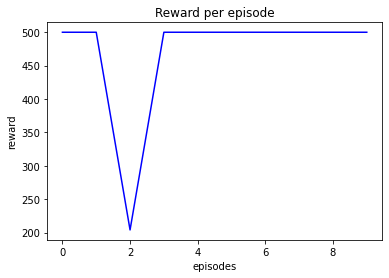

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        probs = actor.policy(torch.from_numpy(state).float().unsqueeze(0))
        action = Categorical(probs).sample().item()#.numpy()
        
        # observation, reward, done,terminal_state_reached, action_new
        next_state, reward, done,_ = env.step(action)
        
        curr_episode_reward += reward

        # Move to the next state
        state = next_state

        if done:
            break 
   
    rewards_per_episode.append(curr_episode_reward)
   

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()
#plt.savefig("Gridworld_evaluation.png",dpi=1200)




# A2C LunarLander(Without buffer)

In [ ]:
%matplotlib notebook
%matplotlib inline

In [ ]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image
from gym import spaces


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
!pip install gym[box2d]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.1 MB/s 
     |████████████████████████████████| 18.3 MB 1.5 MB/s 
     |████████████████████████████████| 1.8 MB 44.6 MB/s 


In [ ]:
class Actor(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Actor, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None

          #self.action_space_len = action_space_len
          self.actor_net = nn.Sequential(nn.Linear(state_space_len, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, action_space_len))
      
    def policy(self,x):
      output = self.actor_net(x)
      return F.softmax(output, dim=-1)
    
    
class Critic(nn.Module):
    
    def __init__(self,state_space_len=None,
                  action_space_len=None):
          super(Critic, self).__init__()

          assert state_space_len is not None
          assert action_space_len is not None
          
          self.critic_net = nn.Sequential(nn.Linear(state_space_len, 128), nn.ReLU(), nn.Linear(128, 256), nn.ReLU(), nn.Linear(256, 1))

          
          
    def v(self,x):
      
      return self.critic_net(x)
    

In [ ]:
def calculate_discountedRewards(rewards,V,dones,gamma = 0.99):
    # bootstrapping from last value
    vals = []
    i = len(rewards)-1
    while i!=-1:
      V = rewards[i] + gamma * V * dones[i]
      vals.insert(0,V)
      i-=1
    return vals


In [ ]:
from collections import defaultdict

def train_step(log_prob_actions,values,rewards,dones,last_value):
    drewards = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach()
    
    advantages = drewards - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    

    optimizer_actor.step()
    optimizer_critic.step()



episode =  0 mean reward =  -322.8251918072438
episode =  100 mean reward =  -135.68217420982694
episode =  200 mean reward =  -114.96928045822501
episode =  300 mean reward =  -116.97263054568802
episode =  400 mean reward =  -108.45486241784921


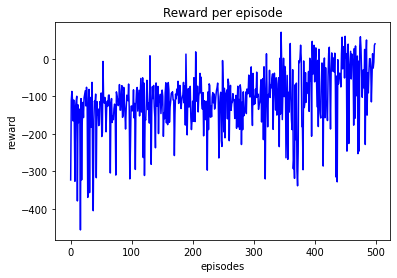

episode =  500 mean reward =  -42.4901953801384
episode =  600 mean reward =  11.948700598362358
episode =  700 mean reward =  35.34520755350168
episode =  800 mean reward =  87.29585957741888
episode =  900 mean reward =  108.41802838778364


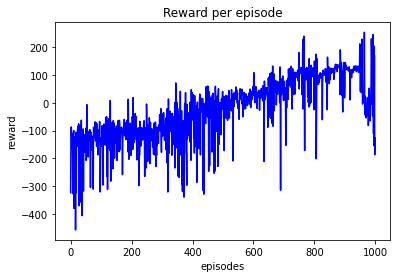

episode =  1000 mean reward =  23.896354599049104
episode =  1100 mean reward =  42.358830094634115
episode =  1200 mean reward =  128.5884710927853
episode =  1300 mean reward =  86.45536361573738
episode =  1400 mean reward =  133.35883104780083


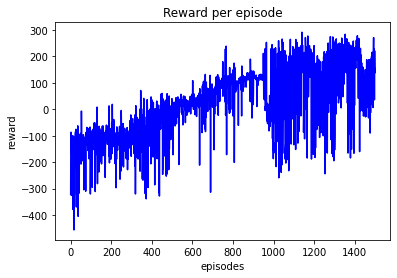

episode =  1500 mean reward =  118.73887929188191
mean_reward> 200
Complete


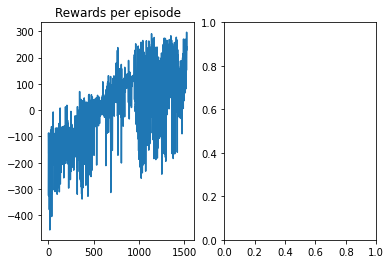

In [ ]:
#from numpy.random.mtrand import seed
#from gym.spaces.discrete import Discrete # Scale reward [-1,1]
from torch.distributions import Categorical
#BATCH_SIZE = 64 #200 # around 32 for cartpole
GAMMA = 0.99 #0.999

learning_rate_critic = 1e-2
learning_rate_actor = 1e-3



#max_step = 100 #2000
num_episodes = 2000
rewards_per_episode = []

env = gym.make("LunarLander-v2")
#torch.manual_seed(321)
env.seed(1234)
#Discrete
n_actions = env.action_space.n


actor = Actor(env.observation_space.shape[0],env.action_space.n)
critic = Critic(env.observation_space.shape[0],env.action_space.n)


optimizer_actor = optim.Adam(actor.parameters(),lr = learning_rate_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=learning_rate_critic)




for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    log_prob_actions = []
    values = []
    rewards = []
    dones = []
    curr_episode_reward = 0
    env.seed(1234)

    for t in count():
        # Select and perform an action    
        
        state = torch.FloatTensor(state)
        probs = actor.policy(state) # actor
        value = critic.v(state)  #critic

        dist = Categorical(probs)
        action = dist.sample()

        log_prob_action = dist.log_prob(action).unsqueeze(0) #get log probabilities

        state, reward, done,_ = env.step(action.cpu().numpy())
        
        log_prob_actions.append(log_prob_action)
        values.append(value)
        rewards.append(torch.tensor([reward], dtype=torch.float))
        dones.append(torch.tensor([1 - done], dtype=torch.float))
        curr_episode_reward += reward
        
        if done:
            break

    last_value = critic.v(torch.FloatTensor(state))
    log_prob_actions = torch.cat(log_prob_actions)
    values = torch.cat(values)
    #TD_target = torch.cat(calculate_TD(rewards,last_value,dones)).detach()
    
    advantages = torch.cat(calculate_discountedRewards(rewards,last_value,dones)).detach() - values
    
    # Calculate loss
    actor_loss = -(log_prob_actions * advantages.detach()).mean()
    
    critic_loss = advantages.pow(2).mean()
    
    
    # Backprop gradients
    optimizer_actor.zero_grad()
    optimizer_critic.zero_grad()
    actor_loss.backward()
    critic_loss.backward()
    optimizer_actor.step()
    optimizer_critic.step()
    #train_step(log_prob_actions,values,rewards,dones,last_value)


    

    rewards_per_episode.append(curr_episode_reward)
    mean_reward = (np.mean(rewards_per_episode[-50:]))
    if i_episode % 100 == 0:
        
        print('episode = ',i_episode, "mean reward = ", mean_reward)
    
    if mean_reward> 180:
      print("mean_reward> 200")
      break
    if (i_episode+1)%500==0:

      plt.title("Reward per episode")
      plt.xlabel('episodes')
      plt.ylabel('reward')
      plt.plot(rewards_per_episode, color="blue")
      plt.show()
      
      

print('Complete')
fig, ax = plt.subplots(1, 2)
ax[0].set_title('Rewards per episode')
ax[0].plot(rewards_per_episode)

# ax[1].set_title('Epsilon decay')
# ax[1].plot(epsilon_per_episode)

#plt.savefig("Assignment2_GridWorld.png",dpi=1200)
plt.show()

Complete


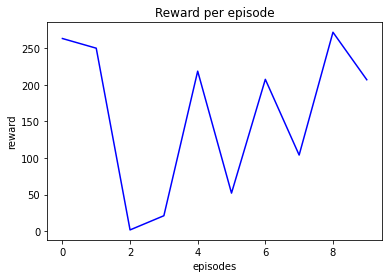

In [ ]:
# Evaluation for 10 episodes
eval_epsiodes = 10
rewards_per_episode = []
for i_episode in range(eval_epsiodes):
    # Initialize the environment and state
    state = env.reset()
    curr_episode_reward = 0
    epsilon = 0
    
    for t in count():
        # Select and perform an action    
        probs = actor.policy(torch.from_numpy(state).float().unsqueeze(0))
        action = Categorical(probs).sample().item()#.numpy()
        
        next_state, reward, done,_ = env.step(action)
        curr_episode_reward += reward
        
        # Move to the next state
        state = next_state
        if done:
            break
    
    rewards_per_episode.append(curr_episode_reward)

print('Complete')
plt.title("Reward per episode")
plt.xlabel('episodes')
plt.ylabel('reward')
plt.plot(rewards_per_episode, color="blue")
plt.show()


# PPO #

In [ ]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
import gym.spaces as spaces
import numpy as np
import torch.nn as nn
import torch
import torch.nn.functional as f
from torch.distributions import Categorical
import random

import pygame

In [ ]:
class Memory:
    def __init__(self,size):
        self.size = size
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []
        self.advantages = []
        self.dis_rewards = []
        self.probs = []
        self.v_values = []
        self.count = 0
        self.last_ep_index = 0
        
    def Array(self):
        self.states = np.array(self.states)
        self.actions = np.array(self.actions)
        self.rewards = np.array(self.rewards)
        self.dones = np.array(self.dones)
        self.next_states = np.array(self.next_states)
        self.advantages = np.array(self.advantages)
        self.dis_rewards = np.array(self.dis_rewards)
        self.probs = np.array(self.probs)
        self.v_values = np.array(self.v_values)
        
    def Add(self, state,action,reward,done,next_state,prob,v_value,adv,dis_reward):
        if(self.count < self.size):
            self.count += 1
        else:
            self.states.pop(0)
            self.actions.pop(0)
            self.rewards.pop(0)
            self.dones.pop(0)
            self.next_states.pop(0)
            self.advantages.pop(0)
            self.dis_rewards.pop(0)
            self.probs.pop(0)
            self.v_values.pop(0)
            self.last_ep_index -= 1
        
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.dones.append(done)
        self.next_states.append(next_state)
        self.advantages.append(adv)
        self.dis_rewards.append(dis_reward)
        self.probs.append(prob)
        self.v_values.append(v_value)
    
    def calculateDiscountedReward(self, gamma, last_v):
        dis_reward = 0
        discount = 1
        td_target = last_v
        adv = 0
        for j in range(self.count-2):
            for i in range(j,self.count-2):
                adv += discount * (self.rewards[i] + (gamma * self.v_values[i+1] * (1-self.dones[i])) - self.v_values[i])
                discount *= gamma*0.5
            self.advantages[j] = adv
            
            
    def createBatch(self,batch_size):
        batch_start = np.arange(0,self.count-1,batch_size)
        indx = np.arange(self.count-1)
        np.random.shuffle(indx)
        batches = [indx[i:i+batch_size] for i in batch_start]
        return batches
        
    def Clear(self):
        self.states = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.next_states = []
        self.advantages = []
        self.dis_rewards = []
        self.probs = []
        self.v_values = []
        self.count = 0
        self.last_ep_index = 0
                 

In [ ]:
class Q_Network(nn.Module):
    def __init__(self,state_space, action_space, node_count):
        super(Q_Network,self).__init__()
        
        self.network = nn.Sequential(nn.Linear(state_space,node_count),
                                    nn.ReLU(),
                                    nn.Linear(node_count,node_count*2),
                                    nn.ReLU(),nn.Linear(node_count*2,action_space))
    
    def forward(self,state):
        output = self.network(state)
        values = f.softmax(output,dim=-1)
        return values
    
class V_Network(nn.Module):
    def __init__(self,state_space, node_count):
        super(V_Network,self).__init__()
        self.network = nn.Sequential(nn.Linear(state_space,node_count),
                                nn.ReLU(),nn.Linear(node_count,node_count*2),
                                nn.ReLU(),nn.Linear(node_count*2,1))
    
    def forward(self,state):
        value = self.network(state)
        return value

In [ ]:
class PPO:
    def __init__(self,env,node_count, state_space, action_space, eps, gamma, lr):
        self.env = env
        self.state_space = state_space
        self.action_space = action_space
        self.QNetwork = Q_Network(state_space,action_space,node_count)
        self.VNetwork = V_Network(state_space,node_count)
        self.QOptim = torch.optim.Adam(params=self.QNetwork.parameters(), lr = lr)
        self.VOptim = torch.optim.Adam(params=self.VNetwork.parameters(),lr = lr)
        self.memory = Memory(1000)
        self.gamma = gamma
        self.eps = eps
    
    def getAction(self, state):
#         print(state)
        state = state.unsqueeze(0)
        with torch.no_grad():
            q_values = self.QNetwork(state)
            v_value = self.VNetwork(state)
        dist = Categorical(q_values)
        action = dist.sample()
        
        probs = torch.squeeze(dist.log_prob(action)).item()
        action = torch.squeeze(action).item()
        v_value = torch.squeeze(v_value).item()
        
        return probs, action, v_value
    
    def Learn(self, batch_size):
        total_rewards = []
        steps = 0
        eps_count = 2000
        quat_way = 500
        
        for i in range(eps_count):
            state = self.env.reset()
            
            total_reward = 0
            done = False
            while not done:
                steps += 1
                state = np.reshape(state, (1,self.state_space))
                probs,action,v_value = self.getAction(torch.tensor(state,dtype = torch.float32).to('cpu'))
                next_state,reward,done,_ = self.env.step(action)
                
                self.memory.Add(state,action,reward,done,np.reshape(next_state,(1,self.state_space)),probs,v_value,0,0)
                total_reward += reward
                if(steps%256 == 0):
                    self.Update(batch_size)
                
            
            total_rewards.append(total_reward)
            if(i%quat_way == 0):
                print("Episode: ", i)
                print("Total Reward: ", total_reward)
        return total_rewards    
                
    
    def Update(self, batch_size):
        self.memory.Array()
        for _ in range(10):
            batches = self.memory.createBatch(batch_size)
            self.memory.calculateDiscountedReward(self.gamma, 0)
            
            for b in batches:
                actions = torch.tensor(self.memory.actions[b],dtype = torch.float32)
                
                states = torch.tensor(self.memory.states[b],dtype = torch.float32)
                with torch.no_grad():
                    q_values = self.QNetwork(states)
                    new_vs = self.VNetwork(states)
                dist = Categorical(q_values)
                new_probs = torch.squeeze(dist.log_prob(actions))
                new_vs = torch.squeeze(new_vs)
            
                new_probs = torch.tensor(new_probs,dtype = torch.float32).to('cpu')
                new_vs = torch.tensor(new_vs,dtype = torch.float32)
                old_probs = torch.tensor(self.memory.probs[b],dtype = torch.float32).to('cpu')
                old_vs = torch.tensor(self.memory.v_values[b],dtype = torch.float32).to('cpu')
                dis_reward = torch.tensor(self.memory.dis_rewards[b],dtype = torch.float32).to('cpu')
        
                advs = torch.tensor(self.memory.advantages[b],dtype = torch.float32).to('cpu')

                ratio = new_probs.exp() / old_probs.exp()

                set_1 = ratio * advs
                set_2 = torch.clamp(ratio, 1-self.eps, 1+self.eps) * advs
                q_loss = -torch.min(set_1,set_2).mean()

                returns = advs + old_vs
                v_loss = (returns - new_vs)**2
                v_loss = 0.5*v_loss.mean()
        
                loss = q_loss + v_loss
        
                loss.requires_grad_()
                self.QOptim.zero_grad()
                self.VOptim.zero_grad()
                loss.backward()
                self.QOptim.step()
                self.VOptim.step()
        self.memory.Clear()
        
        
                

In [ ]:
def avg_reward(total_rewards):
    avg_rewards = []
    for i in range(len(total_rewards)):
        avg = 0
        if(i < 100):
            avg = sum(total_rewards[0:i])/(i+1)
        else:
            avg = sum(total_rewards[i-100:i])/(100)
        avg_rewards.append(avg)
    return avg_rewards

In [ ]:
env = gym.make('CartPole-v1')

ppo = PPO(env, 128, 4, 2, 0.2, 0.99, 0.0003)

total_rewards = ppo.Learn(64)

Episode:  0
Total Reward:  24.0


/tmp/ipykernel_2912/359328694.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_probs = torch.tensor(new_probs,dtype = torch.float32).to('cpu')
/tmp/ipykernel_2912/359328694.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_vs = torch.tensor(new_vs,dtype = torch.float32)


Episode:  500
Total Reward:  20.0
Episode:  1000
Total Reward:  23.0
Episode:  1500
Total Reward:  21.0


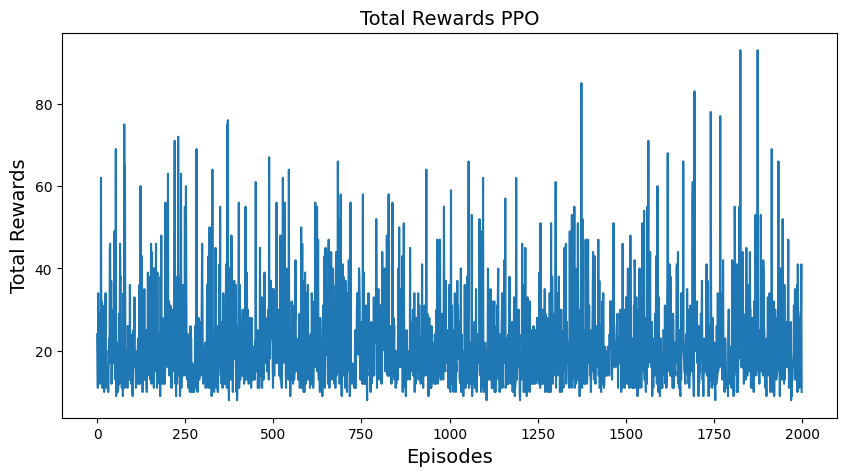

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(total_rewards)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('Total Rewards PPO', color = "black", fontsize = 14)
plt.show()

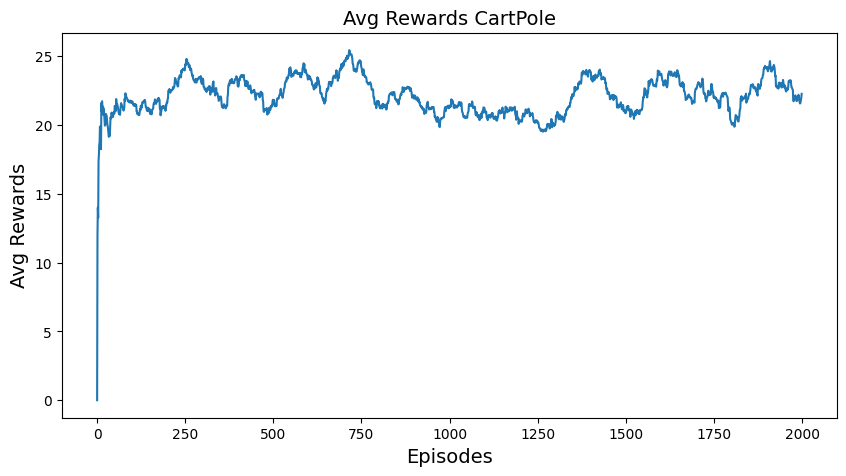

In [ ]:
avg_rewards = avg_reward(total_rewards)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(avg_rewards)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Avg Rewards", color = "black", fontsize = 14)
plt.title('Avg Rewards CartPole', color = "black", fontsize = 14)
plt.show()

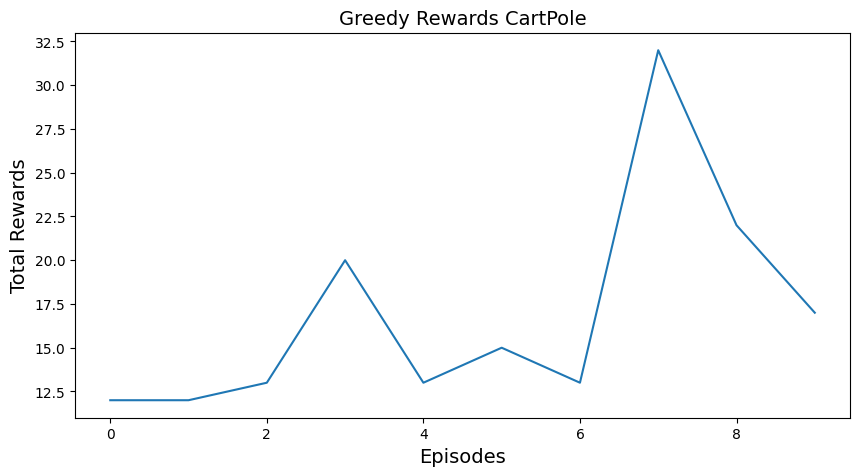

In [ ]:


total_rewards = []

for i in range(10):
    done = False
    total_reward = 0
    state = env.reset()
    while not done:
        state = np.reshape(state, (1,4))
        prob,action,_ = ppo.getAction(torch.tensor(state,dtype=torch.float32))
        next_state,reward,done,_ = env.step(action)
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)
    
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(total_rewards)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('Greedy Rewards CartPole', color = "black", fontsize = 14)
plt.show()

In [ ]:
class GridWorld(gym.Env):

    def __init__(self):
        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 12
        self.r1_pos = np.asarray([0,2])
        self.r2_pos = np.asarray([1,1])
        self.r3_pos = np.asarray([2,1])

    def reset(self):
        self.timestep = 0
        self.goal_pos = [2,2]
        self.agent_pos = [0,0]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 2
        self.state[tuple(self.goal_pos)] = 0.75
        self.state[tuple(self.r1_pos)] = 0.3
        self.state[tuple(self.r3_pos)] = 0.4
        self.state[tuple(self.r2_pos)] = 0.2
        obs = self.state.flatten()
        obs = np.array(obs)
#         obs = self.get_state()
        return obs
    
    def get_state(self):
        pose = self.agent_pos
        p1 = pose[0]
        p2 = pose[1]
        state = p1*4 + p2
        return state

    def step(self, action):
        if action == 0:
            self.agent_pos[0] += 1 
        if action == 1:
            self.agent_pos[0] -= 1
        if action == 2:
            self.agent_pos[1] += 1
        if action == 3:
            self.agent_pos[1] -= 1
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
        self.state = np.zeros((4,4))
        
        self.state[tuple(self.goal_pos)] = 0.75
        self.state[tuple(self.r1_pos)] = 0.3
        self.state[tuple(self.r3_pos)] = 0.4
        self.state[tuple(self.r2_pos)] = 0.2
        self.state[tuple(self.agent_pos)] = 1
        obs = self.state.flatten()
        obs = np.array(obs)
#         obs = self.get_state()
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
            reward = 10
        elif(self.agent_pos == self.r1_pos).all():
            reward = 1
        elif(self.agent_pos == self.r2_pos).all():
            reward = -5
        elif(self.agent_pos == self.r3_pos).all():
            reward = 3
            
        self.timestep += 1

        goal_done = True if (self.agent_pos == self.goal_pos).all() else False
        time_done = True if self.timestep >= self.max_timesteps else False

        done = False
        if(goal_done == True or time_done == True):
          done = True
        
        info = {}
        
        return obs, reward, done, info

    def render(self):
        fig = plt.figure()
        ax1 = fig.add_subplot(111,aspect='equal')
        ax1.set_yticks([int(j) for j in range(0,4)])
        ax1.set_xticks([int(j) for j in range(0,4)])
        plt.imshow(self.state)
    

In [ ]:
grid_env = GridWorld()

grid_ppo = PPO(grid_env, 32, 16, 4, 0.2, 0.99, 0.0003)

total_rewards = grid_ppo.Learn(64)


Episode:  0
Total Reward:  11


/tmp/ipykernel_2912/359328694.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_probs = torch.tensor(new_probs,dtype = torch.float32).to('cpu')
/tmp/ipykernel_2912/359328694.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_vs = torch.tensor(new_vs,dtype = torch.float32)


Episode:  500
Total Reward:  -4
Episode:  1000
Total Reward:  13
Episode:  1500
Total Reward:  -10


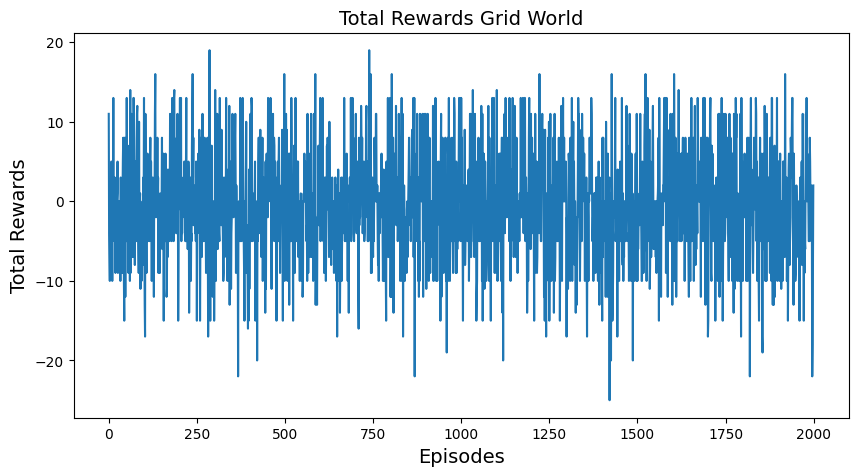

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(total_rewards)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('Total Rewards Grid World', color = "black", fontsize = 14)
plt.show()

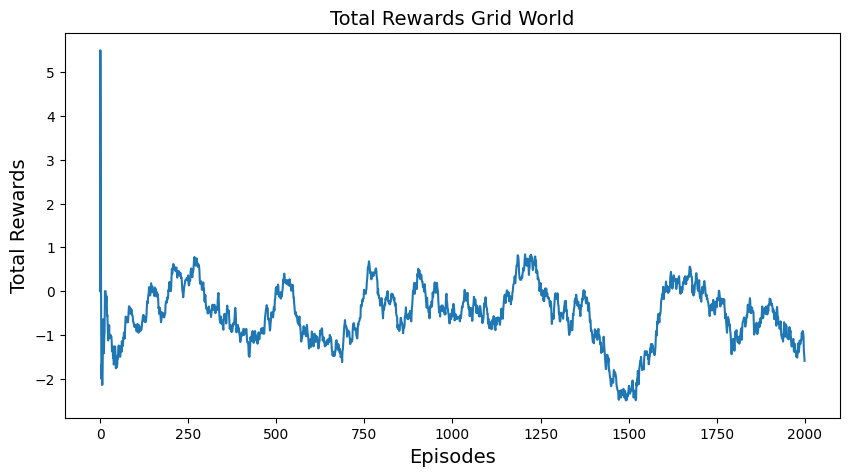

In [ ]:
avg_rewards = avg_reward(total_rewards)
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(avg_rewards)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('Total Rewards Grid World', color = "black", fontsize = 14)
plt.show()

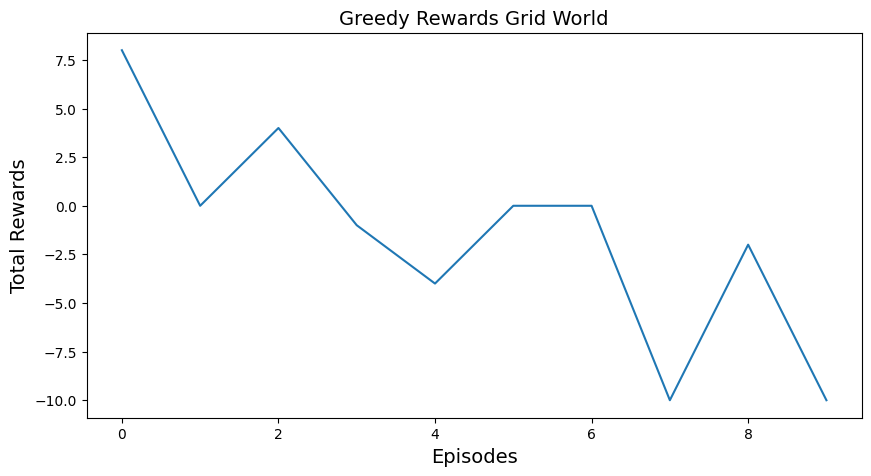

In [ ]:
total_rewards = []

for i in range(10):
    done = False
    total_reward = 0
    state = grid_env.reset()
    while not done:
        state = np.reshape(state, (1,16))
        prob,action,_ = grid_ppo.getAction(torch.tensor(state,dtype=torch.float32))
        next_state,reward,done,_ = grid_env.step(action)
        state = next_state
        total_reward += reward
    total_rewards.append(total_reward)
    
fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(total_rewards)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Total Rewards", color = "black", fontsize = 14)
plt.title('Greedy Rewards Grid World', color = "black", fontsize = 14)
plt.show()

In [ ]:
!pip install gym[box2d]

  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
  Using cached pygame-2.1.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [41 lines of output]
      Using setuptools (version 65.6.0).
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build/lib.linux-x86_64-cpython-38
      creating build/lib.linux-x86_64-cpython-38/Box2D
      copying library/Box2D/__init__.py -> build/lib.linux-x86_64-cpython-38/Box2D
      copying library/Box2D/Box2D.py -> build/lib.linux-x86_64-cpython-38/Box2D
      creating build/lib.linux-x86_64-cpython-38/Box2D/b2
      copying library/Box2D/b2/__init__.py -> build/lib.linux-x86_64-cpython-38/Box2D/b2
      running build_ext
      building 'Box2D._Box2D' extension
      swigging Box2D/Box2D.i to Box2D/Box2D_wrap.cpp
      swig -p

In [ ]:
ll_env = gym.make('LunarLander-v2')


DependencyNotInstalled: box2D is not installed, run `pip install gym[box2d]`